# Taxi Demand Prediction 

## Table of Content
1. Introduction
2. What we want to know?
3. Solution
4. Our Approach
    1. Dataset
    2. Data Processing
    3. Basic analysis on the dataset

## 1. Introduction

The taxicabs of New York City are widely recognized icons of the city. Between 210 and 240 million people take taxis each year. New York City taxicabs transport about 600,000 people per day. There are two varieties of taxis: yellow and green. Yellow Taxis are able to pick up passengers anywhere in Manhattan, the Bronx, Queens, Brooklyn, and Staten Island. Green Taxis are able to pick up passengers in Upper Manhattan, the Bronx, Brooklyn, Queens, and Staten Island.

The New York City Taxi & Limousine Commission has released a staggeringly detailed historical dataset covering over 1.1 billion yellow and green taxi trips in the city for all of 2014 and up to June 2016. The data isn't just about the coordinates of the taxi pickup and dropoff locations, this detailed dataset further uncovers the various characteristics of the trips, including pick-up and drop-off dates and times, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.  


We want to exploit an understanding of these taxi trips, extract the stories and meaing from the trip data. And we want to utilize the data to 
1. **Increase the efficiency of the taxi system** by making suggestions for taxi where to go next while it is in service so that it can maximize its earning. To achieve our goal, we hope to discover the demands of the service, what are the best locations in different datetimes for an autonomous vehicle to travel by analyzing the Taxi trip data collected and provided by the technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP)
2. **Make the trip information such as travel time and price transparent to passengers** through estimation


## 2. What we want to know?
*What is the relevant data, and how you can use this data to answer the question at hand?*

Given a specific location, date and time, can we predict the demand of the taxi service (number of pickups in that location)? How well is our prediction? What are the best locations, date and times for a taxi to travel to so it can reach the highest demand?

Our secondary objective is to know that given a pickup location, destination, and date and time, can we estimate the travel time and price of the taxi trip? And how accurate is the estimation?


## 3. Solution
1. Taxi demand prediction: Predict taxi demand over a week with **regression model**
2. Travel time and price estimation: Estimate travel time and price based on origin and destination so that customers know the estimates before their ride. We will use features available only before a ride for the estimation, such as origin coodinates, destination coodinates, time, ground-circle distance, weather

## 4. Our Approach
### 4.1. Dataset
The datasets we use are:
1. **New York Taxi trip data** collected and provided by the technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP).
The trip data include:
    * The yellow and green taxi trip records
    The trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. 
    * The For-Hire Vehicle (“FHV”) trip records
    These trip records include fields capturing the dispatching base license number and the pick-up date, time, and taxi zone location ID 
    * Shapefile containing the boundaries for the taxi zones
2. **Weather data** - historical hourly weather data using forceast.io provided by The Dark Sky Company


Given we have limited computational resources for this project, we reduce the size of our data by only considering the taxi trip data from **June 2016 in (or originate from) Manhattan, New York**, and the same constraint is applied to our weather data.  



### 4.2 Gather weather data

We extract the weather data using the API in weather.com.
And the columns are listed in here:
"summary","temperature","apparentTemperature", "cloudCover", "windSpeed", "humidity", "precipType", "precipProbability", "precipIntensity".

In [ ]:
#pip install python-forecastio
import datetime
import pandas as pd
import forecastio

# Enter your API here
api_key = "2f2f6bfbbbfeb4acd65e9342ab04658b"

lat = 40.78
lng = -73.97



attributes = ["summary","temperature","apparentTemperature", "cloudCover", "windSpeed", "humidity", "precipType", "precipProbability", "precipIntensity"]


times = []
data = {}
for attr in attributes:
    data[attr] = []


start = datetime.datetime(2016,5,30)
for offset in range(1, 32):
    forecast = forecastio.load_forecast(api_key, lat, lng, time=start+datetime.timedelta(offset), units="us")
    h = forecast.hourly()
    d = h.data
    for p in d:
        times.append(p.time)
        for attr in attributes:
            if attr in p.d:
                data[attr].append(p.d[attr])
            else:
                data[attr].append("")

df = pd.DataFrame(data, index=times)

# df = df.tz_localize("Asia/Kolkata").tz_convert("US/Central")
# df.head()
df.to_csv("weather.csv")


### 4.3. Data Processing
Given we have limited computational resources for this project, we have pre-processed the dataset to only include the taxi trip data and weather data from June 2016 in Manhattan, New York. 

For this part, I need to clean the taxi data and combine the taxi data and weather data.

In the NYC, there are two tpyes of taxi,yellow taxi and green taxi. And the attributes in these two data have a litte differences. So we need to unified the attributes first. 

Then, for taxi bussiness, the demand in workday is very different from the demand in weekend. And the demand in daytime is very different from the demand at night. So, we extract the day and hour from the timestamp, and divide the days into 1 to 7 which means Monday to Sunday. 

After the whole processing, there are 11 columns in the taxi data. The columns are listed in here:
'pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','trip_distance','fare_amount','tip_amount','total_amount'.


In [ ]:
import pandas as pd
import numpy as np

#green taxi data
df = pd.read_csv('/Users/guoqing/Downloads/green_tripdata_2016-06.csv')
df.lpep_pickup_datetime = pd.to_datetime(pd.Series(df.lpep_pickup_datetime))
dates = pd.DatetimeIndex(df.lpep_pickup_datetime)
df['dateofmonth'] = dates.day
df['hourofday'] = dates.hour
df['dayofweek'] = df.reset_index()['lpep_pickup_datetime'].dt.dayofweek
df = df.drop(['VendorID','Extra','MTA_tax'],1)
df['time'] =df.lpep_pickup_datetime.map(lambda t: t.strftime('%Y/%m/%d %H:00'))
df.time = pd.to_datetime(pd.Series(df.time))
greencolumn = ['lpep_pickup_datetime','Lpep_dropoff_datetime','Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude','Passenger_count','Trip_distance','Fare_amount','Tip_amount','Total_amount']
newcolumn = ['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','trip_distance','fare_amount','tip_amount','total_amount']
df.rename(columns=dict(zip(greencolumn, newcolumn)), inplace=True)
#print df

#yellow taxi data
yellowdf = pd.read_csv('/Users/guoqing/Downloads/yellow_tripdata_2016-06.csv')
yellowdf.tpep_pickup_datetime = pd.to_datetime(pd.Series(yellowdf.tpep_pickup_datetime))
dates2 = pd.DatetimeIndex(yellowdf.tpep_pickup_datetime)
yellowdf['dateofmonth'] = dates2.day
yellowdf['hourofday'] = dates2.hour
yellowdf['dayofweek'] = yellowdf.reset_index()['tpep_pickup_datetime'].dt.dayofweek
yellowdf['time'] = yellowdf.tpep_pickup_datetime.map(lambda t: t.strftime('%Y/%m/%d %H:00'))
yellowdf.time = pd.to_datetime(pd.Series(yellowdf.time))
yellowdf = yellowdf.drop(['VendorID','extra','mta_tax','store_and_fwd_flag','RatecodeID','payment_type','tolls_amount','improvement_surcharge'],1)
yellowcolumn = ['tpep_pickup_datetime','tpep_dropoff_datetime']
newyellowcolumn = ['pickup_datetime','dropoff_datetime']
yellowdf.rename(columns=dict(zip(yellowcolumn, newyellowcolumn)), inplace=True)
#print yellowdf.columns
result = df.append([yellowdf])

wdf = pd.read_csv('/Users/guoqing/Downloads/weather.csv')
wdf['time']= pd.to_datetime(pd.Series(wdf[wdf.columns[0]]))
wdf = wdf.drop(wdf.columns[0],axis=1)
finalresult = pd.merge(wdf, result, on='time', how='right')
finalresult.to_csv('/Users/guoqing/Downloads/finaldata.csv')

### 4.4. Basic analysis on the dataset

To better understand our dataset, we did the exploratory data analysis after pre-procssing the data.

In [1]:
import geopandas as gpd
import shapely
import rtree
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn
seaborn.set_style("white")

# matplotlib.rc("figure", figsize=(8,6))
# matplotlib.rc("axes", labelsize=16, titlesize=16)
# matplotlib.rc("xtick", labelsize=14)
# matplotlib.rc("ytick", labelsize=14)
# matplotlib.rc("legend", fontsize=14)
# matplotlib.rc("font", size=14)

### 4.4.1 Loading data and plotting
First let's load taxi zone data provided in the shapefile format.

In [2]:
df_nyc = gpd.read_file("taxi_zones/taxi_zones.shp");
df_nyc.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,geometry,zone
0,1,1,0.000782,0.116357,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",Newark Airport
1,2,2,0.004866,0.433470,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",Jamaica Bay
2,3,3,0.000314,0.084341,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",Allerton/Pelham Gardens
3,4,4,0.000112,0.043567,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",Alphabet City
4,5,5,0.000498,0.092146,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",Arden Heights


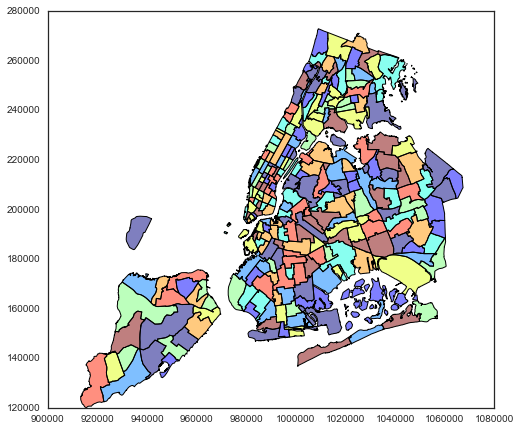

In [3]:
df_nyc.plot(figsize=(8,8), cmap="jet");

In [6]:
df = pd.read_csv('whole_finaldata.csv', nrows=1)
df.columns

Index([u'Unnamed: 0', u'apparentTemperature', u'cloudCover', u'humidity',
       u'precipIntensity', u'precipProbability', u'precipType', u'summary',
       u'temperature', u'windSpeed', u'time', u'dateofmonth', u'dayofweek',
       u'dropoff_datetime', u'dropoff_latitude', u'dropoff_longitude',
       u'fare_amount', u'hourofday', u'passenger_count', u'pickup_datetime',
       u'pickup_latitude', u'pickup_longitude', u'tip_amount', u'total_amount',
       u'trip_distance'],
      dtype='object')

Let's load nyc taxi dataset next. We are using date and only pickup location for now.

In [6]:
df_pickup = pd.read_csv('whole_finaldata.csv', usecols=[
        u'dateofmonth',
        u'dayofweek',
        u'hourofday',
        u'pickup_latitude',
        u'pickup_longitude',
    ], dtype={
        'dateofmonth': np.int8,
        'dayofweek' : np.int8, 
        'hourofday' : np.int8,
        'pickup_latitude' : np.float32,
        'pickup_longitude': np.float32})
df_pickup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12184044 entries, 0 to 12184043
Data columns (total 5 columns):
dateofmonth         int8
dayofweek           int8
hourofday           int8
pickup_latitude     float32
pickup_longitude    float32
dtypes: float32(2), int8(3)
memory usage: 220.8 MB


In [7]:
df_pickup.head()

,dateofmonth,dayofweek,hourofday,pickup_latitude,pickup_longitude
0,1,2,0,40.746685,-73.944031
1,1,2,0,40.700611,-73.807480
2,1,2,0,40.678753,-73.995644
3,1,2,0,40.699291,-73.807915
4,1,2,0,40.844788,-73.937065


### 4.4.2. Aggregate the trip data based on taxi zone

After we have our data ready, we then group the trip information based on the taxi zone. 
Here, we define clean_sjoin function, which filters dataset and conducts spacial join on the GIS data.

In [8]:
def clean_sjoin(df, gdf, loc_col=None):
    if not loc_col:
        loc_col = ['pickup_longitude', 'pickup_latitude']
    df["geometry"] = [shapely.geometry.Point(loc[0], loc[1]) for loc in df[loc_col].values]
    df = df[df["geometry"].apply(lambda x : x is not None)]
    df = df.to_crs(gdf.crs)
    df = gpd.sjoin(df, gdf[["geometry"]], how="inner", op="within")
    return df

### 4.4.3 Operation trend on a given day
Let's visualize spacial distribution of taxi demand on given day. We choose June 1st (Tuesday). We are using the two different time zone: morning (6am-10am) and evening (18pm-22pm).

In [28]:
df_Tmorning = gpd.GeoDataFrame(df_pickup[df_pickup.dateofmonth==1][df_pickup.hourofday>=6] [df_pickup.hourofday<10], crs="+proj=latlon")
df_Tmorning = clean_sjoin(df_Tmorning, df_nyc)
df_nyc["demand_Tmorning"] = df_Tmorning.groupby("index_right").count().iloc[:,0]

In [29]:
df_Tevening = gpd.GeoDataFrame(df_pickup[df_pickup.dateofmonth==1][df_pickup.hourofday>=18] [df_pickup.hourofday<22], crs="+proj=latlon")
df_Tevening = clean_sjoin(df_Tevening, df_nyc)
df_nyc["demand_Tevening"] = df_Tevening.groupby("index_right").count().iloc[:,0]

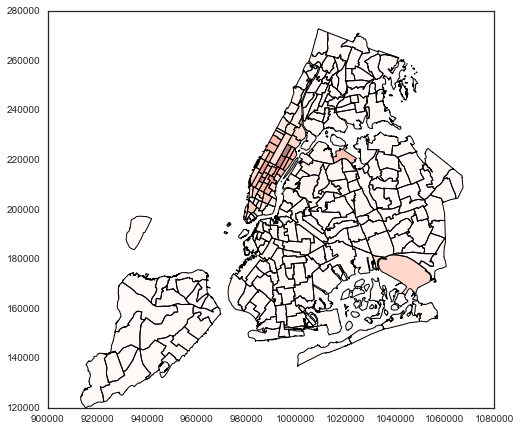

In [39]:
df_nyc.plot(column='demand_Tmorning', cmap="Reds", figsize=(8,8));

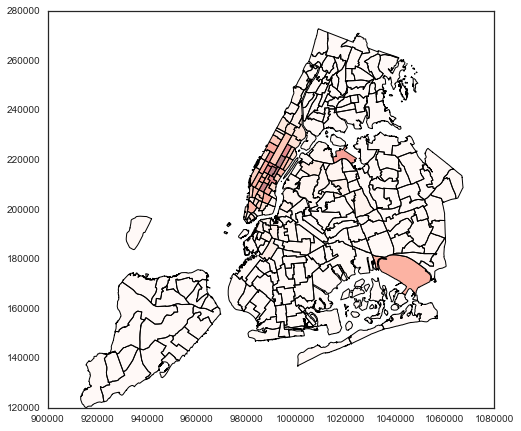

In [40]:
df_nyc.plot(column='demand_Tevening', cmap="Reds", figsize=(8,8));

Next, let's visualize the demand change over a week in the entire city.

In [9]:
df_count = df_pickup.groupby(['dateofmonth', 'dayofweek', 'hourofday'])[['pickup_latitude']].count()
df_count = df_count.rename(columns={'pickup_latitude':'pickup_count'}).reset_index()
df_count = df_count.groupby(['dayofweek', 'hourofday'])['pickup_count'].mean()
df_count.head()

dayofweek  hourofday
0          0            9602.25
           1            5913.50
           2            3826.75
           3            2615.25
           4            2983.75
Name: pickup_count, dtype: float64

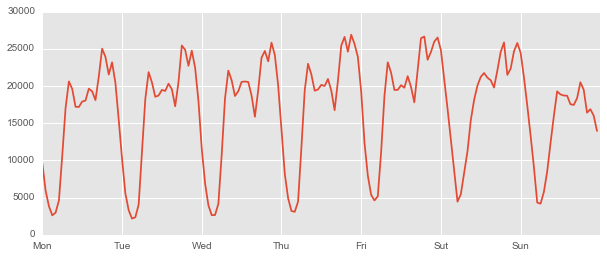

In [20]:
plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.plot(np.arange(df_count.shape[0]), df_count.values)
plt.xlim([0, 24*7])
plt.xticks(np.arange(0, 24*7+1, 24), 'Mon Tue Wed Thu Fri Sut Sun'.split())
plt.show()

Now, let's look at the price and trip distance relationship

In [1]:
df_price = pd.read_csv('whole_finaldata.csv', usecols=[
        u'trip_distance',
        u'total_amount',
    ], dtype={
        'trip_distance' : np.float32,
        'total_amount': np.float32})
df_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12184044 entries, 0 to 12184043
Data columns (total 2 columns):
total_amount     float32
trip_distance    float32
dtypes: float32(2)
memory usage: 185.9 MB


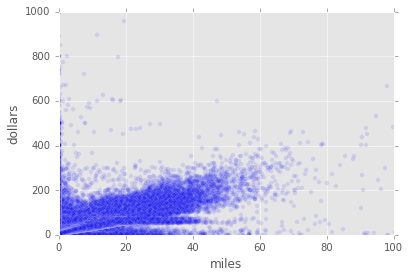

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
plt.scatter(df_price.trip_distance, df_price.total_amount, alpha=0.1)
plt.xlim([0, 100])
plt.ylim([0, 1000])
plt.xlabel('miles')
plt.ylabel('dollars')
plt.show()